In [33]:
import re
import pandas as pd
import string
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import numpy as np

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data processing 

In [35]:
# Load and preprocess the data
data = pd.read_csv('IMDB-sentiment-analysis-master/IMDB-Dataset.csv')

In [36]:
# Removing HTML tags
def clean_html(text):
    clean = re.compile('<.*?>')
    cleantext = re.sub(clean, '', text)
    return cleantext

# First round of cleaning
def clean_text1(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Second round of cleaning
def clean_text2(text):
    text = re.sub('[''"",,,]', '', text)
    text = re.sub('\n', '', text)
    return text

In [37]:
data['review'] = data['review'].apply(clean_html).apply(clean_text1).apply(clean_text2)

In [38]:
# Build vocabulary manually and encode
max_features = 5000
counter = Counter([word for review in data['review'] for word in review.split()])
most_common = counter.most_common(max_features - 2)  # Reserve spots for <pad> and <unk>
vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}  # +2 to reserve 0 for <pad>, 1 for <unk>
vocab['<pad>'] = 0
vocab['<unk>'] = 1

In [39]:
def encode(text):
    return [vocab.get(token, vocab['<unk>']) for token in text.split()]

data['encoded_review'] = data['review'].apply(encode)

In [40]:
# Pad sequences to maxlen
maxlen = 600
def pad_sequence_custom(sequence, maxlen=maxlen, padding_value=vocab['<pad>']):
    return torch.tensor(sequence[:maxlen] + [padding_value] * (maxlen - len(sequence)), dtype=torch.long)

data['padded_review'] = data['encoded_review'].apply(pad_sequence_custom)
X = torch.stack(data['padded_review'].tolist())

In [41]:
# Convert labels to binary
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
Y = torch.tensor(data['sentiment'].values, dtype=torch.long)

# Split dataset

In [42]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [43]:
# Create DataLoader for batching
batch_size = 64
train_data = TensorDataset(X_train, Y_train)
test_data = TensorDataset(X_test, Y_test)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Simple RNN

In [44]:
# Define the RNN model for sentiment analysis
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(EncoderRNN, self).__init__()
        """
        N: num batches (sentences).
        D: Each token is represented by a D-dimensional embedding vector (embed_size).
        T: Maximum sequence length (number of words in each sequence)
        H: hidden_size

        shape input: (N, T)
        shape embeded input: (N, T, D)
        
        for each word in the sentence:
            next_h = torch.tanh(x.mm(Wx) + prev_h.mm(Wh) + b)
            {
                where:
                x:      (N,D)
                Wx:     (D,H)
                Wh:     (H,H)
                b:      (H,)
                next_h: (N,H)
            }
            (This is one step in the image above.)
        
        This process repeats for all the words in the sentence, so the number of output or hidden states at the end is T.

        output: (N, T, H)
        """
        self.embedding = nn.Embedding(vocab_size, embed_size) # assigne a vector of embec_size to each word
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)

        self.hidden_dim = hidden_size
        
    def forward(self, x):
        """
        hidden: (N, H)
        """        
        x = self.embedding(x)
        output, hidden = self.rnn(x)
        return hidden
    

class DecoderRNN(nn.Module):
    def __init__(self, output_dim, hidden_dim):
        super(DecoderRNN, self).__init__()
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
        self.hidden_dim = hidden_dim

    def forward(self, hidden):
        batch_size = hidden.size(1)
        input = torch.zeros(batch_size, 1, self.hidden_dim).to(hidden.device)  # [batch_size, 1, hidden_dim]
        outputs, hidden = self.rnn(input, hidden)
        
        # Pass final RNN output to linear layer
        prediction = self.fc(outputs.squeeze(1))  # prediction = [batch_size, output_dim]
        return self.sigmoid(prediction).squeeze() 
    

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src):
        hidden = self.encoder(src)
        output = self.decoder(hidden)
        return output

# LSTM

In [45]:
# Define the LSTM model
class SentimentLSTM(nn.Module):
    def __init__(self, max_features, embed_dim, lstm_out, num_classes=2):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(max_features, embed_dim)
        self.lstm = nn.LSTM(embed_dim, lstm_out, batch_first=True)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(lstm_out, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        out = self.fc(h_n[-1])  # Using the last hidden state
        return out

# GRU

In [46]:
# Define the GRU model
class SentimentGRU(nn.Module):
    def __init__(self, max_features, embed_dim, gru_out, num_classes=2):
        super(SentimentGRU, self).__init__()
        self.embedding = nn.Embedding(max_features, embed_dim)
        self.gru = nn.GRU(embed_dim, gru_out, batch_first=True, dropout=0.2)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(gru_out, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        gru_out, h_n = self.gru(x)
        out = self.fc(h_n[-1])  # Using the last hidden state
        return out


In [47]:
def train(model, optimizer, criterion, num_epochs=16):
    # Lists to store losses and accuracies
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training and validation loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()
                
                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(test_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Plotting training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.show()

    # Final accuracy on the validation set
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

    # Additional Evaluation Metrics (Confusion Matrix, Precision, Recall, F1-Score)
    from sklearn.metrics import classification_report, confusion_matrix

    # Gathering predictions for detailed evaluation
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print the classification report and confusion matrix
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

# Train Simple RNN

Epoch [1/16], Train Loss: 0.6936, Train Accuracy: 50.23%, Val Loss: 0.6930, Val Accuracy: 49.84%
Epoch [2/16], Train Loss: 0.6927, Train Accuracy: 50.23%, Val Loss: 0.6935, Val Accuracy: 49.81%
Epoch [3/16], Train Loss: 0.6912, Train Accuracy: 50.92%, Val Loss: 0.6951, Val Accuracy: 49.68%
Epoch [4/16], Train Loss: 0.6881, Train Accuracy: 51.27%, Val Loss: 0.6961, Val Accuracy: 49.75%
Epoch [5/16], Train Loss: 0.6855, Train Accuracy: 51.44%, Val Loss: 0.6969, Val Accuracy: 49.81%
Epoch [6/16], Train Loss: 0.6837, Train Accuracy: 51.65%, Val Loss: 0.6967, Val Accuracy: 49.87%
Epoch [7/16], Train Loss: 0.6825, Train Accuracy: 51.80%, Val Loss: 0.6963, Val Accuracy: 49.87%
Epoch [8/16], Train Loss: 0.6816, Train Accuracy: 51.95%, Val Loss: 0.6971, Val Accuracy: 49.85%
Epoch [9/16], Train Loss: 0.6811, Train Accuracy: 52.01%, Val Loss: 0.6961, Val Accuracy: 49.98%
Epoch [10/16], Train Loss: 0.6810, Train Accuracy: 51.93%, Val Loss: 0.6972, Val Accuracy: 49.78%
Epoch [11/16], Train Loss: 0.

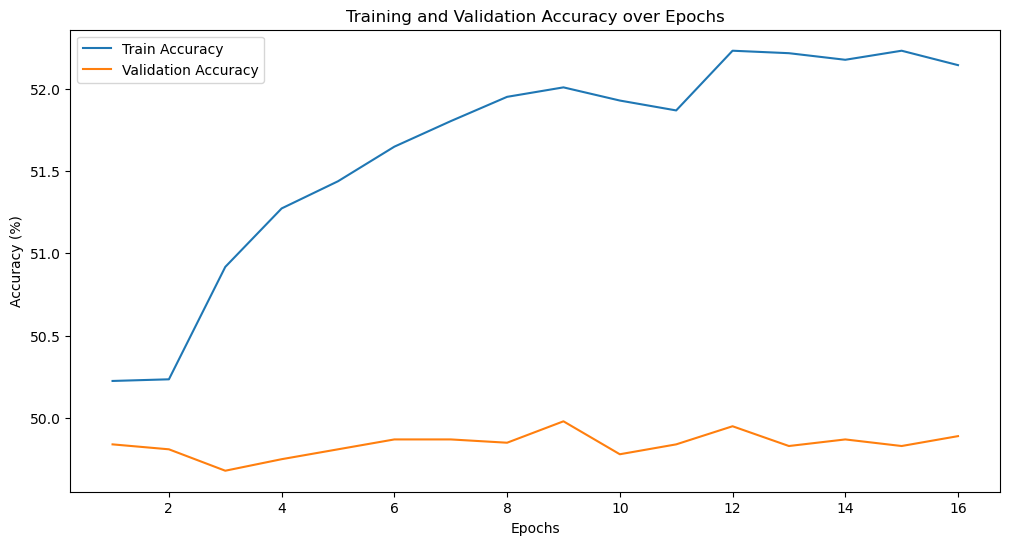

Final Validation Accuracy: 49.89%
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.98      0.66      4961
           1       0.55      0.03      0.06      5039

    accuracy                           0.50     10000
   macro avg       0.53      0.50      0.36     10000
weighted avg       0.53      0.50      0.35     10000

Confusion Matrix:
 [[4843  118]
 [4893  146]]


In [48]:
# Instantiate the model, define the loss function and optimizer
vocab_size = max_features  # As per your dataset
embed_size = 128
hidden_size = 128
output_size = 2  # Assuming binary classification: positive or negative sentiment
learning_rate = 0.001
encoder = EncoderRNN(vocab_size, embed_size, hidden_size)
decoder = DecoderRNN(output_size, hidden_size)
model = Seq2Seq(encoder, decoder).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, optimizer, criterion, 16)

# Train LSTM

Epoch [1/16], Train Loss: 0.6938, Train Accuracy: 50.30%, Val Loss: 0.6931, Val Accuracy: 49.97%
Epoch [2/16], Train Loss: 0.6925, Train Accuracy: 49.94%, Val Loss: 0.6940, Val Accuracy: 50.02%
Epoch [3/16], Train Loss: 0.6907, Train Accuracy: 50.28%, Val Loss: 0.6946, Val Accuracy: 50.02%
Epoch [4/16], Train Loss: 0.6872, Train Accuracy: 50.86%, Val Loss: 0.6963, Val Accuracy: 50.02%
Epoch [5/16], Train Loss: 0.6835, Train Accuracy: 51.16%, Val Loss: 0.7064, Val Accuracy: 50.05%
Epoch [6/16], Train Loss: 0.6781, Train Accuracy: 51.98%, Val Loss: 0.7050, Val Accuracy: 50.10%
Epoch [7/16], Train Loss: 0.6745, Train Accuracy: 51.73%, Val Loss: 0.7113, Val Accuracy: 50.10%
Epoch [8/16], Train Loss: 0.6718, Train Accuracy: 52.23%, Val Loss: 0.7215, Val Accuracy: 50.74%
Epoch [9/16], Train Loss: 0.6706, Train Accuracy: 52.26%, Val Loss: 0.7267, Val Accuracy: 50.03%
Epoch [10/16], Train Loss: 0.6696, Train Accuracy: 51.50%, Val Loss: 0.7279, Val Accuracy: 50.09%
Epoch [11/16], Train Loss: 0.

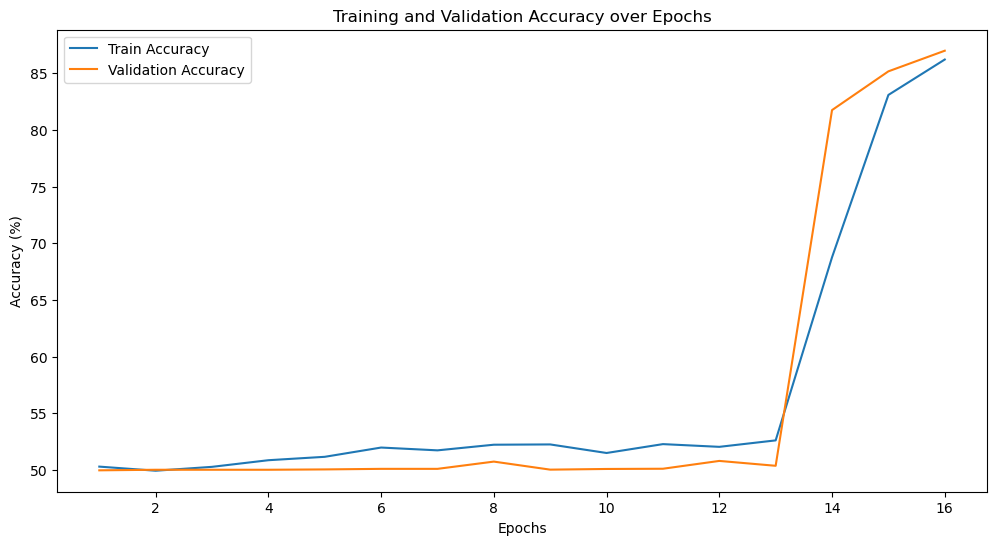

Final Validation Accuracy: 87.00%
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.86      4961
           1       0.85      0.90      0.88      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Confusion Matrix:
 [[4149  812]
 [ 488 4551]]


In [49]:
# Model parameters
embed_dim = 128
lstm_out = 128
model = SentimentLSTM(max_features, embed_dim, lstm_out).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, optimizer, criterion, 16)

# Train GRU

/home/mahdi/miniconda3/envs/ml2/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch [1/16], Train Loss: 0.6972, Train Accuracy: 50.25%, Val Loss: 0.6941, Val Accuracy: 49.89%
Epoch [2/16], Train Loss: 0.6938, Train Accuracy: 50.13%, Val Loss: 0.6930, Val Accuracy: 49.99%
Epoch [3/16], Train Loss: 0.6886, Train Accuracy: 52.77%, Val Loss: 0.6640, Val Accuracy: 61.77%
Epoch [4/16], Train Loss: 0.5598, Train Accuracy: 71.51%, Val Loss: 0.4145, Val Accuracy: 82.41%
Epoch [5/16], Train Loss: 0.4149, Train Accuracy: 81.39%, Val Loss: 0.3405, Val Accuracy: 85.59%
Epoch [6/16], Train Loss: 0.3263, Train Accuracy: 86.09%, Val Loss: 0.2829, Val Accuracy: 88.66%
Epoch [7/16], Train Loss: 0.2903, Train Accuracy: 87.83%, Val Loss: 0.2597, Val Accuracy: 89.47%
Epoch [8/16], Train Loss: 0.2602, Train Accuracy: 89.33%, Val Loss: 0.2814, Val Accuracy: 89.08%
Epoch [9/16], Train Loss: 0.2464, Train Accuracy: 90.03%, Val Loss: 0.2611, Val Accuracy: 89.45%
Epoch [10/16], Train Loss: 0.2290, Train Accuracy: 90.46%, Val Loss: 0.2500, Val Accuracy: 89.83%
Epoch [11/16], Train Loss: 0.

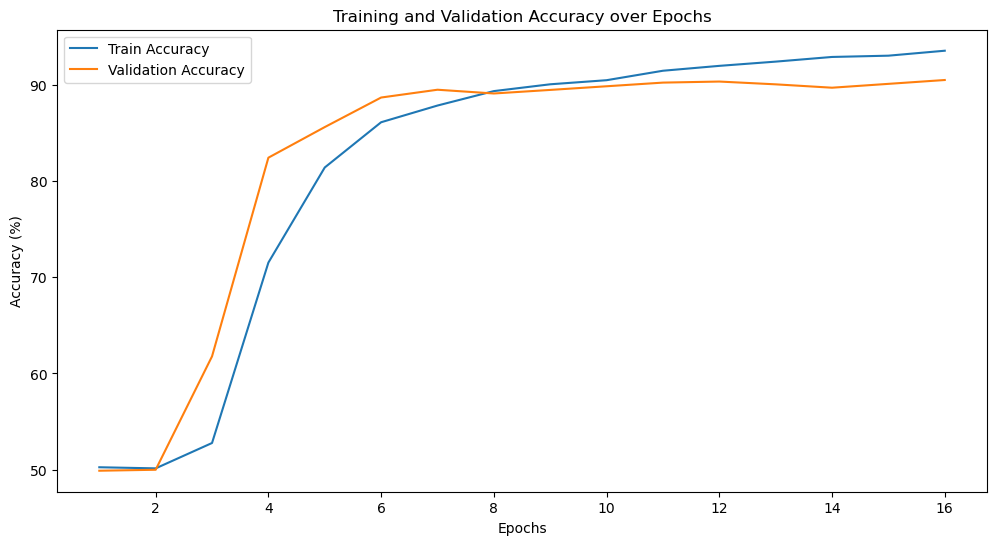

Final Validation Accuracy: 90.48%
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      4961
           1       0.91      0.91      0.91      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Confusion Matrix:
 [[4483  478]
 [ 474 4565]]


In [50]:
# Model parameters
embed_dim = 128
lstm_out = 128
model = SentimentGRU(max_features, embed_dim, lstm_out).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, optimizer, criterion, 16)

نتایج به خوبی مشخص هستند که مد آر ان ان اصلا دقت خوبی بدست نیاورد. اما بعد از چند ایپاک ال اس تی ام دقت خوبی بدست آورد اما کند بود اما جی آر یو از همان اول دقت خوبی داشت.

# Daily Minimum Temperatures in Melbourne

## Make dataset

In [51]:
# Load the Melbourne Temperature data
data = pd.read_csv('archive/daily-minimum-temperatures-in-me.csv', header=0)  # Adjust the path
temperatures = data['temp'].values.astype(float)

# Normalize the temperature values
# scaler = MinMaxScaler(feature_range=(0, 1))
# temperatures = scaler.fit_transform(temperatures.reshape(-1, 1)).squeeze()

# Set sequence length (number of previous time steps to use for prediction)
sequence_length = 1000

# Create sequences and labels
sequences = []
labels = []
for i in range(len(temperatures) - sequence_length):
    sequences.append(temperatures[i:i + sequence_length])
    labels.append(temperatures[i + sequence_length])

sequences = np.array(sequences)
labels = np.array(labels)

# Convert to tensors
sequences = torch.tensor(sequences, dtype=torch.float32).to(device)
labels = torch.tensor(labels, dtype=torch.float32).to(device)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Create DataLoader objects
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)


In [52]:
# Define the Simple RNN model
class SentimentRNN(nn.Module):
    def __init__(self, max_features, embed_dim, rnn_out, num_classes=2):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(max_features, embed_dim)
        self.rnn = nn.RNN(embed_dim, rnn_out, batch_first=True)
        self.fc = nn.Linear(rnn_out, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        rnn_out, h_n = self.rnn(x)
        out = self.fc(h_n[-1])  # Using the last hidden state
        return out

In [53]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for sequences, labels in train_loader:
            optimizer.zero_grad()
            output = model(sequences.long()).reshape((-1,))
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for sequences, labels in val_loader:
                output = model(sequences.long()).reshape((-1,)) 
                loss = criterion(output, labels)
                val_loss += loss.item()
        if epoch%10 ==0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}')

# Define the evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    
    # Generate predictions
    with torch.no_grad():
        for sequences, labels in data_loader:
            output = model(sequences.long()).reshape((-1,))  # Forward pass
            predictions.extend(output.cpu().numpy())  # Append predictions
            actuals.extend(labels.cpu().numpy())  # Append actual labels
    
    # Calculate MSE, RMSE, and MAE
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}')
    
    return actuals, predictions, mse, rmse, mae

# Define the plotting function
def plot_predictions(actuals, predictions, title='Model Predictions vs Actual'):
    plt.figure(figsize=(10, 5))
    plt.plot(actuals, label="Actual", color='b')
    plt.plot(predictions, label="Predicted", color='r')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Temperature (normalized)")
    plt.legend()
    plt.show()

# Train Simple RNN

Epoch 1/50, Train Loss: 42.92824586469736, Val Loss: 14.700879153083353
Epoch 11/50, Train Loss: 5.781070157663146, Val Loss: 6.011261308894438
Epoch 21/50, Train Loss: 5.292419145356363, Val Loss: 6.00454202820273
Epoch 31/50, Train Loss: 4.982320418998377, Val Loss: 6.205035658443675
Epoch 41/50, Train Loss: 4.524010213453378, Val Loss: 6.459090373095344
MSE: 6.867005348205566, RMSE: 2.620497226715088, MAE: 2.0857458114624023


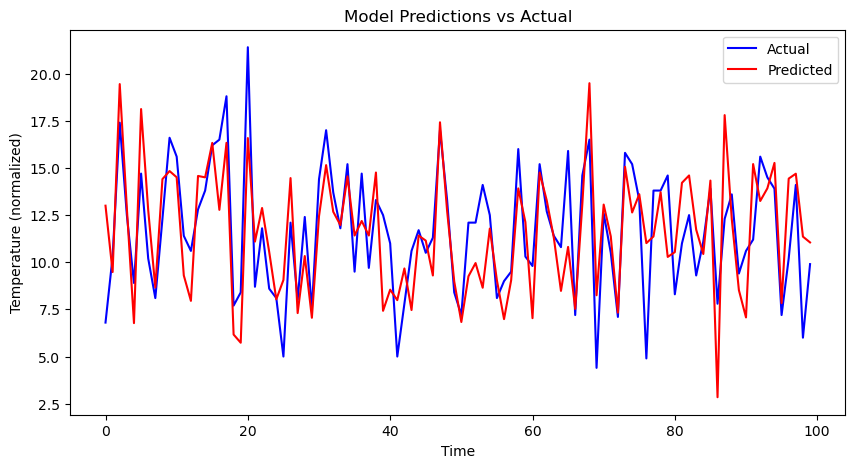

In [54]:
# Model parameters
embed_dim = 128
hidden_size = 128
max_features = sequence_length
model = SentimentRNN(max_features, embed_dim, hidden_size, num_classes=1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer)

# Evaluate on the validation set
actuals, predictions, mse, rmse, mae = evaluate_model(model, val_loader)
plot_predictions(actuals[:100], predictions[:100])  # Plot the first 100 predictions

# Train LSTM

Epoch 1/50, Train Loss: 46.97575690141365, Val Loss: 14.995379532084746
Epoch 11/50, Train Loss: 6.4073374129053375, Val Loss: 6.417222065084121
Epoch 21/50, Train Loss: 5.690741480286442, Val Loss: 5.919643822838278
Epoch 31/50, Train Loss: 5.398291495308947, Val Loss: 5.719638165305643
Epoch 41/50, Train Loss: 5.2169213508492085, Val Loss: 5.732579623951631
MSE: 5.8793816566467285, RMSE: 2.42474365234375, MAE: 1.919477939605713


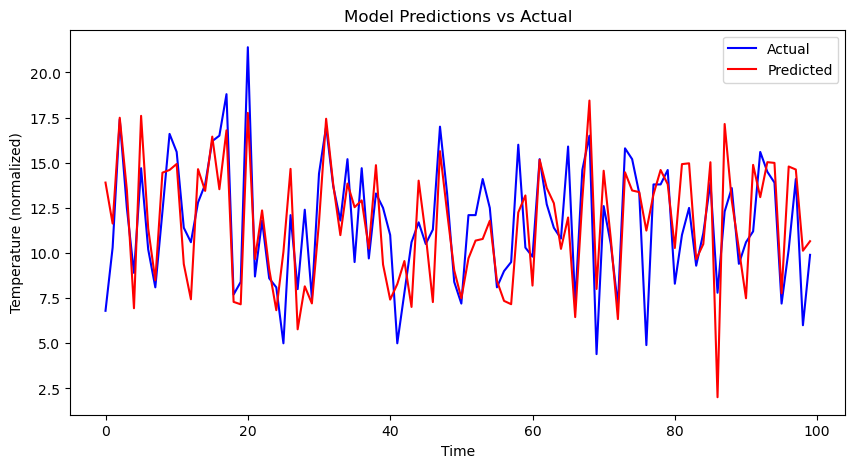

In [55]:
# Model parameters
embed_dim = 64
hidden_size = 128
max_features = sequence_length
model = SentimentLSTM(max_features, embed_dim, hidden_size, num_classes=1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer)

# Evaluate on the validation set
actuals, predictions, mse, rmse, mae = evaluate_model(model, val_loader)
plot_predictions(actuals[:100], predictions[:100])  # Plot the first 100 predictions

# Train GRU

/home/mahdi/miniconda3/envs/ml2/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Train Loss: 44.23080887011628, Val Loss: 14.785089857438031
Epoch 11/50, Train Loss: 5.660942515330528, Val Loss: 6.029845167608822
Epoch 21/50, Train Loss: 5.268418625219544, Val Loss: 5.833333043491139
Epoch 31/50, Train Loss: 5.005735201622123, Val Loss: 5.848667214898502
Epoch 41/50, Train Loss: 4.684615115621197, Val Loss: 5.800496227600995
MSE: 6.12464714050293, RMSE: 2.4748024940490723, MAE: 1.968598484992981


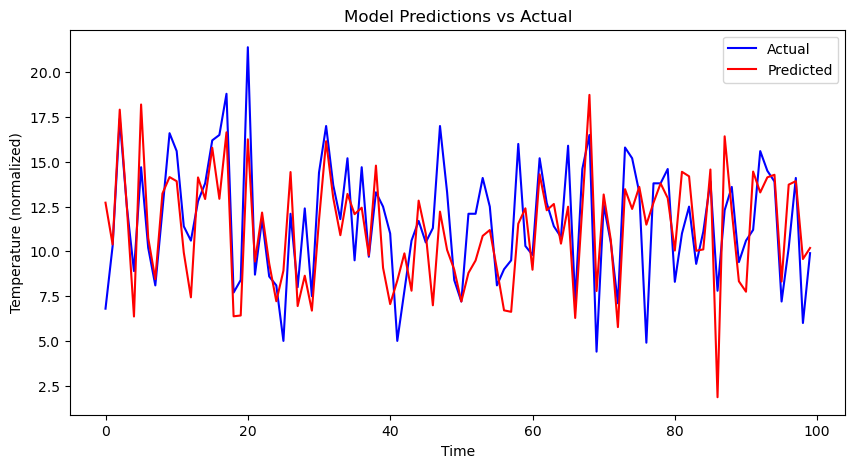

In [56]:
# Model parameters
embed_dim = 128
hidden_size = 128
max_features = sequence_length
model = SentimentGRU(max_features, embed_dim, hidden_size, num_classes=1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer)

# Evaluate on the validation set
actuals, predictions, mse, rmse, mae = evaluate_model(model, val_loader)
plot_predictions(actuals[:100], predictions[:100])  # Plot the first 100 predictions

## Try without embedding layer

In [61]:
# Simple RNN Model
class SentimentRNN(nn.Module):
    def __init__(self, input_size, rnn_out, num_classes=1):
        super(SentimentRNN, self).__init__()
        self.rnn = nn.RNN(input_size, rnn_out, batch_first=True)
        self.fc = nn.Linear(rnn_out, num_classes)
        
    def forward(self, x):
        rnn_out, h_n = self.rnn(x)
        out = self.fc(h_n[-1])  # Using the last hidden state
        return out

# LSTM Model
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, lstm_out, num_classes=1):
        super(SentimentLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, lstm_out, batch_first=True)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(lstm_out, num_classes)
        
    def forward(self, x):
        x = self.dropout(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        out = self.fc(h_n[-1])  # Using the last hidden state
        return out

# GRU Model
class SentimentGRU(nn.Module):
    def __init__(self, input_size, gru_out, num_classes=1):
        super(SentimentGRU, self).__init__()
        self.gru = nn.GRU(input_size, gru_out, batch_first=True, dropout=0.2)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(gru_out, num_classes)
        
    def forward(self, x):
        x = self.dropout(x)
        gru_out, h_n = self.gru(x)
        out = self.fc(h_n[-1])  # Using the last hidden state
        return out

In [62]:
data = pd.read_csv('archive/daily-minimum-temperatures-in-me.csv', header=0)  # Adjust the path if necessary
temperatures = data['temp'].values.astype(float)

# Normalize the temperature values
scaler = MinMaxScaler(feature_range=(0, 1))
temperatures = scaler.fit_transform(temperatures.reshape(-1, 1)).squeeze()

sequence_length = 1000

# Create sequences and labels
sequences = []
labels = []
for i in range(len(temperatures) - sequence_length):
    sequences.append(temperatures[i:i + sequence_length])
    labels.append(temperatures[i + sequence_length])

sequences = np.array(sequences)
labels = np.array(labels)

# Reshape sequences to include a feature dimension (batch_size, seq_length, input_size)
sequences = sequences.reshape(-1, sequence_length, 1)  # input_size=1
labels = labels.reshape(-1, 1)  # Ensure labels have shape (num_samples, 1)

# Convert to tensors
sequences = torch.tensor(sequences, dtype=torch.float32).to(device)
labels = torch.tensor(labels, dtype=torch.float32).to(device)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Create DataLoader objects
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

In [63]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for sequences_batch, labels_batch in train_loader:
            optimizer.zero_grad()
            output = model(sequences_batch).reshape(-1)  # Output shape: (batch_size,)
            loss = criterion(output, labels_batch.squeeze())  # Labels shape: (batch_size,)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for sequences_batch, labels_batch in val_loader:
                output = model(sequences_batch).reshape(-1)
                loss = criterion(output, labels_batch.squeeze())
                val_loss += loss.item()
        
        # Print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# ============================
# Evaluation Function
# ============================

def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for sequences_batch, labels_batch in data_loader:
            output = model(sequences_batch).reshape(-1)
            predictions.extend(output.cpu().numpy())
            actuals.extend(labels_batch.cpu().numpy())
    
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')
    
    return actuals, predictions, mse, rmse, mae

# ============================
# Plotting Function
# ============================

def plot_predictions(actuals, predictions, title='Model Predictions vs Actual'):
    plt.figure(figsize=(10, 5))
    plt.plot(actuals, label="Actual", color='b')
    plt.plot(predictions, label="Predicted", color='r')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()



Training SentimentRNN model...
Epoch 10/50, Train Loss: 0.0085, Val Loss: 0.0080
Epoch 20/50, Train Loss: 0.0087, Val Loss: 0.0079
Epoch 30/50, Train Loss: 0.0083, Val Loss: 0.0076
Epoch 40/50, Train Loss: 0.0086, Val Loss: 0.0081
Epoch 50/50, Train Loss: 0.0083, Val Loss: 0.0078

Evaluating SentimentRNN model...
MSE: 0.0078, RMSE: 0.0886, MAE: 0.0703


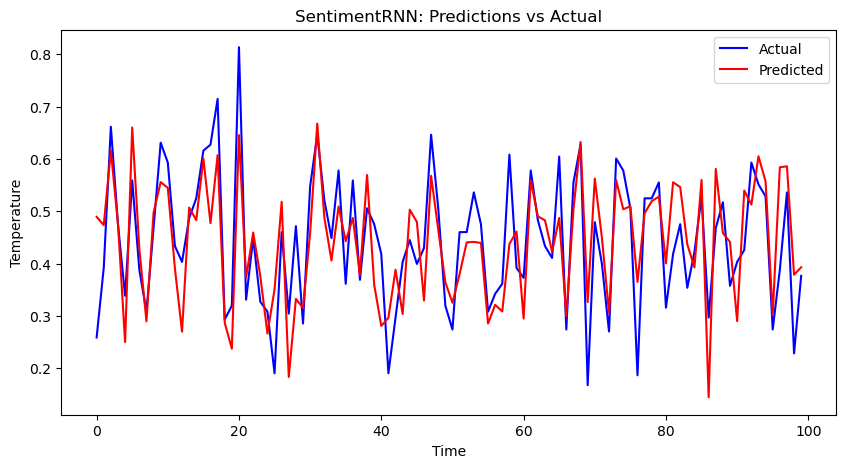


Training SentimentLSTM model...
Epoch 10/50, Train Loss: 0.0137, Val Loss: 0.0122
Epoch 20/50, Train Loss: 0.0133, Val Loss: 0.0113
Epoch 30/50, Train Loss: 0.0126, Val Loss: 0.0114
Epoch 40/50, Train Loss: 0.0115, Val Loss: 0.0179
Epoch 50/50, Train Loss: 0.0098, Val Loss: 0.0335

Evaluating SentimentLSTM model...
MSE: 0.0341, RMSE: 0.1846, MAE: 0.1538


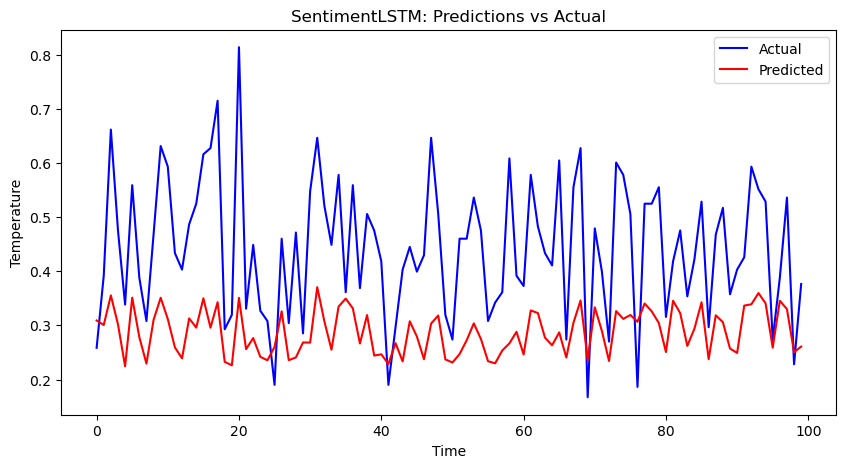


Training SentimentGRU model...


/home/mahdi/miniconda3/envs/ml2/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 10/50, Train Loss: 0.0129, Val Loss: 0.0135
Epoch 20/50, Train Loss: 0.0116, Val Loss: 0.0116
Epoch 30/50, Train Loss: 0.0101, Val Loss: 0.0191
Epoch 40/50, Train Loss: 0.0095, Val Loss: 0.0206
Epoch 50/50, Train Loss: 0.0093, Val Loss: 0.0218

Evaluating SentimentGRU model...
MSE: 0.0222, RMSE: 0.1489, MAE: 0.1189


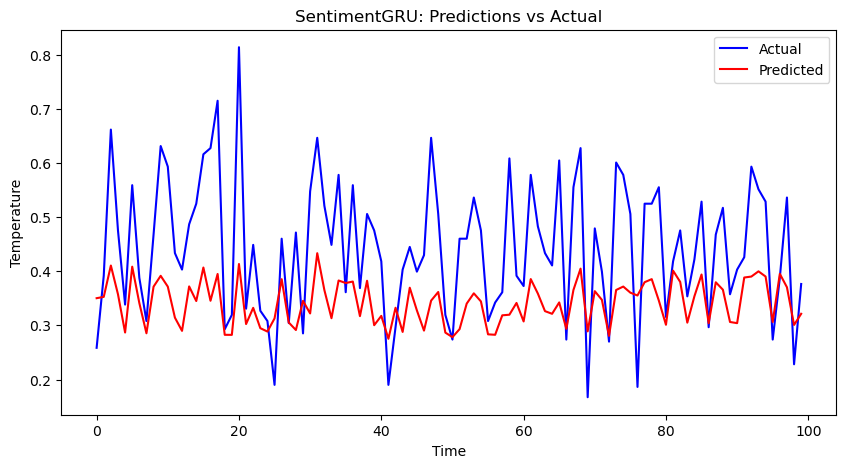

In [64]:
# Model parameters
input_size = 1      # Single feature (temperature)
hidden_size = 128   # Number of hidden units

# ============================
# Training and Evaluating SentimentRNN
# ============================
print("\nTraining SentimentRNN model...")
model_rnn = SentimentRNN(input_size=input_size, rnn_out=hidden_size, num_classes=1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model_rnn.parameters(), lr=0.001)

# Train the RNN model
train_model(model_rnn, train_loader, val_loader, criterion, optimizer, num_epochs=50)

# Evaluate the RNN model
print("\nEvaluating SentimentRNN model...")
actuals_rnn, predictions_rnn, mse_rnn, rmse_rnn, mae_rnn = evaluate_model(model_rnn, val_loader)

# Plot predictions vs actuals for RNN
plot_predictions(actuals_rnn[:100], predictions_rnn[:100], title='SentimentRNN: Predictions vs Actual')

# ============================
# Training and Evaluating SentimentLSTM
# ============================
print("\nTraining SentimentLSTM model...")
model_lstm = SentimentLSTM(input_size=input_size, lstm_out=hidden_size, num_classes=1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

# Train the LSTM model
train_model(model_lstm, train_loader, val_loader, criterion, optimizer, num_epochs=50)

# Evaluate the LSTM model
print("\nEvaluating SentimentLSTM model...")
actuals_lstm, predictions_lstm, mse_lstm, rmse_lstm, mae_lstm = evaluate_model(model_lstm, val_loader)

# Plot predictions vs actuals for LSTM
plot_predictions(actuals_lstm[:100], predictions_lstm[:100], title='SentimentLSTM: Predictions vs Actual')

# ============================
# Training and Evaluating SentimentGRU
# ============================
print("\nTraining SentimentGRU model...")
model_gru = SentimentGRU(input_size=input_size, gru_out=hidden_size, num_classes=1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model_gru.parameters(), lr=0.001)

# Train the GRU model
train_model(model_gru, train_loader, val_loader, criterion, optimizer, num_epochs=50)

# Evaluate the GRU model
print("\nEvaluating SentimentGRU model...")
actuals_gru, predictions_gru, mse_gru, rmse_gru, mae_gru = evaluate_model(model_gru, val_loader)

# Plot predictions vs actuals for GRU
plot_predictions(actuals_gru[:100], predictions_gru[:100], title='SentimentGRU: Predictions vs Actual')